In [ ]:
!pip install pmdarima
!pip install darts

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kstest
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Base Functions

To open data, plot given columns

In [ ]:
def open_data(print_head=False, columns=None):
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Forecasting/LD2011_2014.csv', parse_dates=['LD2011_2014'], index_col='LD2011_2014')
    data.rename(columns={'LD2011_2014': 'Timestamp'}, inplace=True)
    n=0
    for col in data.columns:
        if col != 'timestamp':
            data.rename(columns={col: f"EC_{n}"}, inplace=True)
            n+=1

    def convert_to_float(value):
        try:
            # Replace commas with points and convert to float
            return float(value.replace(',', '.'))
        except:
            # Handle any conversion errors (e.g., non-numeric values)
            return value

    # Apply the custom function to all values in the DataFrame
    data = data.applymap(convert_to_float)

    if columns:
        data = data[columns]

    if print_head:
        print(data.head())

    return data



def plot_data(df, columns=None):
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    elif isinstance(columns, int):
        columns = [df.columns[columns]]
    # Get the list of column names from the DataFrame
    df = df[columns]
    # Determine the number of rows and columns for subplots
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # Adjust this for your layout preference

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(30, num_rows * 4))
    fig.tight_layout(pad=4.0)  # Adjust the padding as needed

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(df.index, df[column])
        ax.set_title(column)
        ax.set_xlabel('Date')  # You can customize the x-axis label
        ax.set_ylabel('Electricity_consumption')  # You can customize the y-axis label

    # Hide any unused subplots (if there are more subplots than columns)
    for j in range(i + 1, num_rows * 2):
        fig.delaxes(axes[j])

    plt.show()

## Base transformations
helps to remove the initial null values
Apply moving average

In [ ]:

def apply_moving_average(df, columns, k):
    """
    Apply a moving average of order k to specified columns of a Pandas DataFrame.

    Parameters:
    - df: Pandas DataFrame.
    - columns: List of column names to apply the moving average to.
    - k: Order of the moving average.

    Returns:
    - df_ma: A new DataFrame with moving averages applied to specified columns.
    """
    if isinstance(columns, str):
        columns = [columns]
    if isinstance(k, int):
        k = [k] * len(columns)  # Convert k to a list of equal values
    elif isinstance(k, str):
        k = [k] * len(columns)

    df_ma = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data

    for i, col in enumerate(columns):
        df_ma[col] = df[col].rolling(window=k[i]).mean()

    return df_ma

def remove_zeros(df, columns= None):

  # # Find the index of the first non-zero value in the column
  #   column_name = df.columns[0]
  #   non_zero_mask = df[column_name] != 0
  #   first_non_zero_index = df[non_zero_mask].index[0]

  #   # Remove the initial rows with zeros
  #   df = df.loc[first_non_zero_index:]

  #   return df

    df_copy = df.copy()
    for k in df_copy.columns:
      # Find the index of the first non-zero value in each column
      non_zero_mask = df_copy[k] != 0.

      first_non_zero_index = df_copy[k][non_zero_mask].index[0]
      if first_non_zero_index >  pd.to_datetime('2012-01-01 00:15:01'):
        print(first_non_zero_index)
      # Remove the initial rows with zeros
      df_copy[k] = df_copy[k].loc[first_non_zero_index:]

    return df_copy

## Fourier Transform

This one is not really used, but it is here for reference
It just shows the fourier transform of the data

In [ ]:
def compute_fourier_transform(df, column_name, plot_spectral_density=False):
    """
    Compute the Fourier transform of a time series column in a Pandas DataFrame.

    Parameters:
    - df: Pandas DataFrame with a time-based index.
    - column_name: Name of the column to perform the Fourier transform on.

    Returns:
    - frequencies: List of frequencies.
    - amplitudes: List of corresponding amplitudes (intensities).
    """

    # Extract the time series data from the specified column
    time_series = df[column_name]

    # Number of data points
    num_points = len(time_series)

    # Calculate the sampling frequency (assuming evenly spaced data)
    try:
        sampling_frequency = 1.0 / (df.index[1] - df.index[0]).total_seconds()
    except:
        sampling_frequency = 1.0 / (df.index[1] - df.index[0])

    # Compute the one-sided FFT
    fft_result = np.fft.fft(time_series)
    fft_frequencies = np.fft.fftfreq(num_points, 1 / sampling_frequency)
    fft_amplitudes = np.abs(fft_result) / num_points  # Normalize by the number of data points
    # Keep only the positive frequencies and their amplitudes
    positive_frequencies = fft_frequencies[:num_points // 2]
    positive_amplitudes = fft_amplitudes[:num_points // 2]

    if plot_spectral_density:
        plt.figure(figsize=(10, 6))
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.show()

    return positive_frequencies, positive_amplitudes


## Remove frequency components:
This function removes frequencies from a signal according to their amplitude, if they are too large or too small
Allows to decompose a signal into its main frequency components

In [ ]:
def remove_periodic_components(df, column_name, frequencies_to_remove=[], threshold=0.1, thresholding="A", plot_spectral_density=False):
    """
    Remove periodic components from a time series column in a Pandas DataFrame by applying inverse FFT.

    Parameters:
    - df: Pandas DataFrame with a time-based index.
    - column_name: Name of the column to process.
    - frequencies_to_remove: List of frequencies to remove (set to zero).
    - threshold: Threshold for setting small amplitudes to zero.
    - thresholding: Type of thresholding to apply to the amplitudes:
        - "A": Amplitudes above the threshold are set to zero.
        - "B": Amplitudes below the threshold are set to zero.

    Returns:
    - df_filtered: A new DataFrame with periodic components removed from the specified column.
    - removed_frequencies: List of frequencies that were removed.
    - removed_amplitudes: List of corresponding amplitudes that were removed.
    """

    df_filtered = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data

    # Extract the time series data from the specified column
    time_series = df[column_name]
    num_points = len(time_series)

    # Perform FFT on the time series data
    fft_result = np.fft.fft(time_series)
    fft_frequencies = np.fft.fftfreq(len(time_series))

    # Set the selected frequencies to remove to zero
    n=0
    for freq_to_remove in frequencies_to_remove:
        if freq_to_remove in fft_frequencies:
            fft_result[np.where(fft_frequencies == freq_to_remove)] = 0
            fft_result[np.where(fft_frequencies == -freq_to_remove)] = 0
        else:
            n+=1

    if n != 0:
        print(f"{n} frequencies not found in the data.")

    # Set amplitudes below/above the threshold to zero and add the removed frequencies and amplitudes to 2 lists
    removed_frequencies = []
    removed_amplitudes = []

    for i, amp in enumerate(fft_result):
        if thresholding == "A":
            if np.abs(amp) > threshold:
                fft_result[i] = 0
                removed_frequencies.append(fft_frequencies[i])
                removed_amplitudes.append(amp)
        elif thresholding == "B":
            if np.abs(amp) < threshold:
                fft_result[i] = 0
                removed_frequencies.append(fft_frequencies[i])
                removed_amplitudes.append(amp)

    """if plot_spectral_density:
        plt.figure(figsize=(10, 6))
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.show()"""

    # Perform iFFT to obtain the filtered time series
    filtered_time_series = np.fft.ifft(fft_result)

    # Update the column in the DataFrame with the filtered time series
    df_filtered[column_name] = filtered_time_series.real

    return df_filtered, removed_frequencies, removed_amplitudes


## Recompose a signal
This function recomposes a signal from its frequency components
It takes a base signal, pass it into frequency domain, and add the missing frequency components (given as input) and reconstruct the full signal

In [ ]:
def inverse_fourier_transform(df, column_name, frequencies_to_add, amplitude_to_add, plot_spectral_density=False):
    """
    Add periodic components from a time series column in a Pandas DataFrame by applying inverse FFT.

    Parameters:
    - df: Pandas DataFrame with a time-based index.
    - column_name: Name of the column to process.
    - frequencies_to_add: List of frequencies to add.
    - amplitude_to_add: Amplitude to add for each frequency.

    Returns:
    - df_filtered: A new DataFrame with periodic components added to the specified column.
    """

    df_filtered = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data
    # Extract the time series data from the specified column
    time_series = df[column_name]

    # Perform FFT on the time series data
    fft_result = np.fft.fft(time_series)
    fft_frequencies = np.fft.fftfreq(len(time_series))

    # Set the selected frequencies to add
    freq_dict = dict(zip(fft_frequencies, fft_result))
    for i, freq_to_add in enumerate(frequencies_to_add):
        if freq_to_add in freq_dict:
            freq_dict[freq_to_add] += amplitude_to_add[i]
        else:
            freq_dict[freq_to_add] = amplitude_to_add[i]

    fft_result = np.array(list(freq_dict.values()))
    fft_frequencies = np.array(list(freq_dict.keys()))

    if plot_spectral_density:
        plt.figure(figsize=(10, 6))
        plt.plot(fft_frequencies, np.abs(fft_result))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.show()

    # Perform iFFT to obtain the filtered time series
    filtered_time_series = np.fft.ifft(fft_result)

    # Update the column in the DataFrame with the filtered time series
    df_filtered[column_name] = filtered_time_series.real[:len(df_filtered)]

    # Create a new dataframe with the filtered time series with a new index
    new_df = pd.DataFrame(filtered_time_series.real, columns=[column_name])

    return new_df

## Noise analysis

Fit the remaining noise to a normal distribution
Plot the noise distribution
Recreate a similar noise distribution

In [ ]:
def fit_n_distribution(data, n=1, plot=False):
    """
    Fit a normal distribution to a dataset and perform a Kolmogorov-Smirnov test for goodness of fit.

    Parameters:
    - data: 1D array of data.
    - n: Number of times to repeat the KS test.
    - plot: Boolean indicating whether to plot the histogram and PDF of the fitted distribution.

    Returns:
    - mu: Mean of the fitted distribution.
    - std: Standard deviation of the fitted distribution.
    - ks_statistic: KS test statistic.
    - ks_p_value: KS test p-value.
    """

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Perform a Kolmogorov-Smirnov test for goodness of fit
    ks_statistic, ks_p_value = kstest(data, 'norm', args=(mu, std))

    if plot:
        # Plot the histogram of the data and the PDF of the fitted distribution
        plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')
        plt.title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
        plt.legend()

        # Print KS test results
        print(f"KS statistic: {ks_statistic}")
        print(f"KS p-value: {ks_p_value}")

        plt.show()

    return mu, std, ks_statistic, ks_p_value

def add_normal_distribution_column(df, column_name = "Time_serie", mu=0, std=1, random_seed=None):
    """
    Add a column of samples from a normal distribution to a Pandas DataFrame.

    Parameters:
    - df: Pandas DataFrame to which the column will be added.
    - column_name: Name of the new column.
    - mu: Mean of the normal distribution.
    - std: Standard deviation of the normal distribution.
    - random_seed: Optional random seed for reproducibility.

    Returns:
    - The modified DataFrame with the new column.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random samples from a normal distribution
    samples = np.random.normal(mu, std, len(df))

    # Add the new column to the DataFrame
    df[column_name] = samples

    return df

## Reduce the number of datapoints

Sum data together to transform 15mins data points to hourly of even daily data points for the electric consumption

In [ ]:
def sum_to_increase_timespace(time, df):
  """
  Parameters :
  - time: number of data that are going to be summed together
          If we want to get hourly data : time = 4
                                  daily data : time = 4*24
  - df: Pandas DataFrame to which the row are going to be added time by time.

  Returns:
  - The modified DataFrame with less points and updated index

  Note:
  - It is implemented such that if data need to be removed because the total number of points can not be divided perfectly by the time,
  the removed data were at the beginning of serie.
  """
  summed_data = pd.DataFrame()
  n = 0
  for k in df.columns :
    n +=1
    # column_name = df.columns[0]
    end = int(time*len(df)/time)
    if n%50 == 0 :
      print(k)
    column_sum = pd.DataFrame({
      k: [df[k][i:i+time].sum() for i in range(end-time*int(len(df)/time), end, time)]},
      index =  df.index[end-time*int(len(df)/time):end:time]
      )

    summed_data = pd.concat([summed_data, column_sum], axis=1)

  return summed_data


## Keep only the interesting data

Remove from the dataset all the clients where the there is too much zeros or the values are too low.

In [ ]:
def keep_important(df, threshold = 35040):
  """
  Input :
  - df a Panda DataFrame with NaN instead of the zeros who are at the beginning of the time series
  - threshold above which you remove the client , 35040 is the common threshold under which most of
  the clients do not have a record of their data. It is equivalent to 12 months.

  Output :
  - A copy of the input without the client which number of points is smaller than a threshold
  """
  data = df.copy()
  nb = 0
  removed_col = []
  for k in data.columns:

    # You can change this code line if you want to choose the clients to remove with another criteria than the number of NaN
    a = data[k].isna().sum()

    if a > threshold :
      nb += 1
      # Remove column k
      removed_col.append(k)
      data = data.drop(k, axis=1)
  print('There are that many column who were removed :', nb)
  print(removed_col)
  return data


## Score of prediction (MAPE)

Calculate the Mean Absolute Percentage Error (MAPE) to determine the accuracy of the model.

In [ ]:
def calculate_mape(actual, predicted, client_list):
  '''
  inputs :
  - Numpy dataframes with one row for each client prediction
  outputs :
  - a vector with the MAPE score for each client whose values have been predicted and the names of the client

  NB:
  if you want to transform the output of the model to a numpy table use this line of code :
  -> df = predictions.output.detach().numpy()
  '''
  mape = []
  n = actual.shape[0]
  for k in range(n):
    actual_k = actual[k,:]+10**(-8)
    predicted_k = predicted[k,:]+10**(-8)
    mape_k = np.mean(np.abs((actual_k - predicted_k) / actual_k))*100 #Calculate the mape for all the predicted value of 1 client
    mape.append(mape_k)

  # Create the DataFrame with the vector and use the list of clients name as column titles
  MAPE_df = pd.DataFrame([mape], columns=client_list)
  return MAPE_df

# Temporal Fusion Transformer




## Data loading and cleaning

In [ ]:
# Open the dataset and charge the dataframe
df_glob = open_data()

In [ ]:
## Clean the data :
# - remove the zeros
# - remove the clients with not enough data
# - sum the data to get daily prediciton and not hourly anymore

df_clients = df = remove_zeros(df=df_glob)
df_Gclients = keep_important(df_clients, threshold = 35040)
df_Gclients_day = sum_to_increase_timespace(4*24, df_Gclients)
df_Gclients_day = remove_zeros(df=df_Gclients_day)

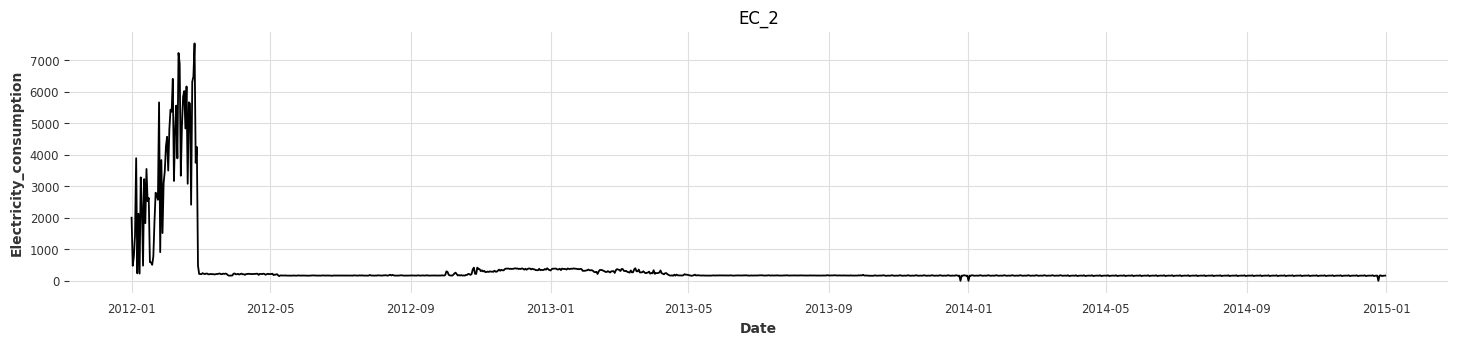

In [ ]:
plot_data(df_Gclients_day, 'EC_2')#["EC_"])

## Test TFT for one client

Darts; https://www.kaggle.com/code/komalnalawade/temporal-fusion-transformer-for-forecast-darts

In [ ]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape as MAPE
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

                             EC_5
LD2011_2014                      
2012-01-01 00:15:00  24907.738095
2012-01-02 00:15:00  23377.976190
2012-01-03 00:15:00  22404.761905
2012-01-04 00:15:00  22842.261905
2012-01-05 00:15:00  21166.666667
...                           ...
2014-12-27 00:15:00  22107.142857
2014-12-28 00:15:00  20139.880952
2014-12-29 00:15:00  22875.000000
2014-12-30 00:15:00  23863.095238
2014-12-31 00:15:00  23523.809524

[1096 rows x 1 columns]


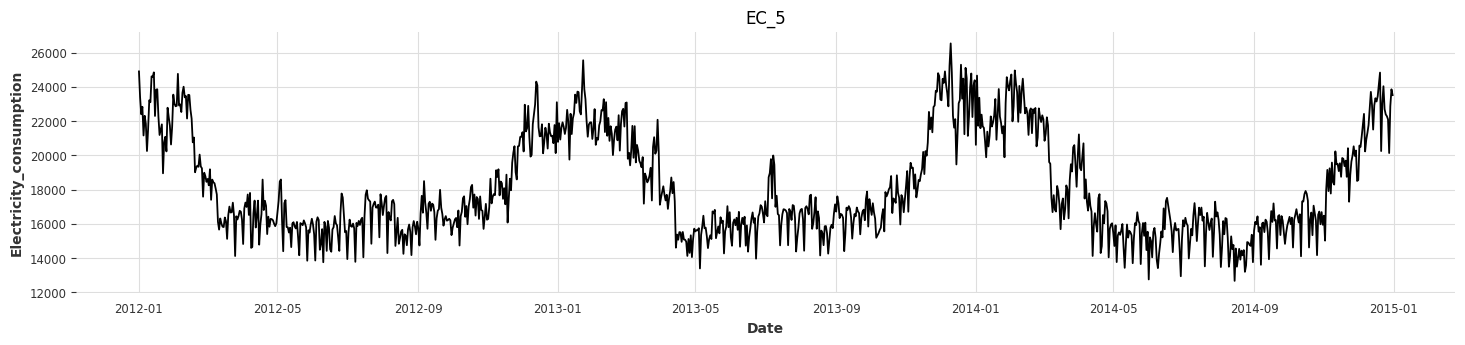

In [ ]:
# Chose the name of the client you want to predict

df_day = df_Gclients_day[["EC_5"]]
df_day =df_day.dropna()
print(df_day)
plot_data(df_day)

In [ ]:
df_day['time'] = df_day.index
name = df_day.columns[0]
df_day.rename(columns={name: 'Electricity'}, inplace=True)
print(df_day)

                      Electricity                time
LD2011_2014                                          
2012-01-01 00:15:00  24907.738095 2012-01-01 00:15:00
2012-01-02 00:15:00  23377.976190 2012-01-02 00:15:00
2012-01-03 00:15:00  22404.761905 2012-01-03 00:15:00
2012-01-04 00:15:00  22842.261905 2012-01-04 00:15:00
2012-01-05 00:15:00  21166.666667 2012-01-05 00:15:00
...                           ...                 ...
2014-12-27 00:15:00  22107.142857 2014-12-27 00:15:00
2014-12-28 00:15:00  20139.880952 2014-12-28 00:15:00
2014-12-29 00:15:00  22875.000000 2014-12-29 00:15:00
2014-12-30 00:15:00  23863.095238 2014-12-30 00:15:00
2014-12-31 00:15:00  23523.809524 2014-12-31 00:15:00

[1096 rows x 2 columns]


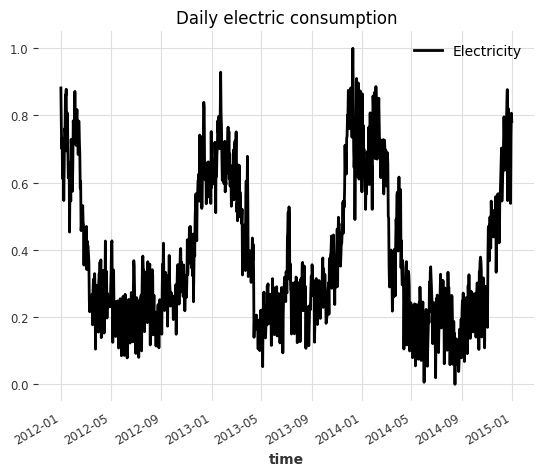

In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
       TimeSeries.from_dataframe(df_day, 'time', 'Electricity', freq='D')
    )
).astype(np.float32)

series.plot()
plt.title("Daily electric consumption")

Nseries = scaler.inverse_transform(series)

In [ ]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20141201001500")
train, val = series.split_after(training_cutoff)


In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="day", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)


scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)


In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = len(train_transformed) - 30
forecast_horizon = 30
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.2,
    batch_size=16,
    n_epochs=500,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [ ]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

In [ ]:
figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
def eval_model(model, n, actual_series, val_series):
    num_samples = len(train_transformed)
    pred_series = model.predict(n=n, num_samples=num_samples)
    # plot actual series
    plt.figure(figsize=figsize)
    Nactual_series = scaler.inverse_transform(actual_series)
    print(pred_series.start_time())
    Nactual_series[pred_series.start_time(): pred_series.end_time()].plot(label="actual")

    # Unscale
    Npred_series = scaler.inverse_transform(pred_series)
    Nval_series = scaler.inverse_transform(val_series)

    # plot prediction with quantile ranges
    Npred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    Npred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    ## Calculate the MAPE for the client and print it
    # First transform the prediction and the validation set to numpy array
    df_val = Nval_series.pd_dataframe()
    val = []
    for k in range(df_val.size):
      val.append(df_val.iloc[k].Electricity)
    np_val = np.array(val)

    df_pred = Npred_series.quantile(0.5).pd_dataframe()
    pred = []
    for k in range(df_pred.size):
      pred.append(df_pred.iloc[k])
    np_pred = np.array(pred)

    # l = len(np_pred)

    # mape = np.mean(np.abs((np_val[:l] - np_pred) / np_val[:l]))*100

    #Calculate the score
    mape = np.mean(np.abs((np_val[:n] - np_pred) / np_val[:n]))*100

    # plt.title("MAPE: {:.2f}%".format(mape))
    plt.title("MAPE: {:.2f}%".format(mape))#MAPE(Nval_series, Npred_series)))

    plt.legend()

eval_model(my_model, 30, series_transformed, val_transformed)

## TFT global prediction

https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

In [ ]:
!pip install pytorch_forecasting

In [ ]:
## Code to set up the utilisation of the GPU for the training

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


Using NVIDIA GeForce GTX 1660 Ti


In [ ]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

In [ ]:
# Transform the dataset to be used by the TFT model from the pytorch_forecasting library

df_elec = pd.melt(df_Gclients_day.reset_index(), id_vars='LD2011_2014', var_name='client', value_name='electricity')
df_elec.columns = ['date', 'client', 'electricity']
df_elec = df_elec.dropna()
print(df_elec)

In [ ]:
# add time index
df_elec["time_idx"] = df_elec["date"].dt.year * 12 + df_elec["date"].dt.month
df_elec["time_idx"] -= df_elec["time_idx"].min()

# add additional features
df_elec["month"] = df_elec.date.dt.month.astype(str).astype("category")  # categories have be strings
df_elec["log_electricity"] = np.log(df_elec.electricity + 1e-8)
df_elec["avg_consumtion_by_client"] = df_elec.groupby(["time_idx", "client"], observed=True).electricity.transform("mean")

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df_elec["time_idx"].max() - max_prediction_length

# Define the characteristic of the trainer
training = TimeSeriesDataSet(
    df_elec[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="electricity",
    group_ids=["client"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["client"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "electricity",
        "log_electricity",
        "avg_consumtion_by_client",
    ],
    target_normalizer=GroupNormalizer(
        groups=["client"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_elec, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(2135.2524)

Model :

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Fine tune the parameters :

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:

predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

In [ ]:
client_list = df_Gclients_day.columns
calculate_mape(predictions.output.detach().numpy(), predictions.y[0].detach().numpy(), client_list)